In [4]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid

In [5]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs
from expbasics.helper import get_attributions, get_model_etc

%reload_ext autoreload
%autoreload 2

In [29]:
BIAS = 0.98

model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS, 0)


In [7]:
BATCH_SIZE = 128
N_BASIS = 4
BATCH_STEP_SIZE = 256
NUM_NEIGHBORS = 36
SPATIAL_STEPSIZE = 1
LAYER_NAME = "linear_layers.1"#"convolutional_layers.7" #
#sample_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, 128)
cavs, idx = load_cavs(LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE)
H = nmf(cavs, N_BASIS)

print(H.shape)

nn_idx = nearest_neighbors(H, cavs, idx, NUM_NEIGHBORS, "cosine")  # , "cosine"
for i in range(N_BASIS):
    vis_nearest_neighbors(unbiased_ds, nn_idx[i], f"{LAYER_NAME}_cosine_{i}")

(4, 6)


In [8]:
cond_layer = "linear_layers.0" #"convolutional_layers.6"#

t = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
told = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
for i in range(N_BASIS):
    for index in range(NUM_NEIGHBORS):
        hold, pred = crp_attribution.heatmap(nn_idx[i][index])
        h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        t[i][index] = h
        told[i][index] = hold

output: tensor([[-5.8499,  7.6585]]), 
 latents: [ 1  3 24  1  6], 
 watermark: True, 
 prediction:1  
 
 convolutional_layers.0: 
 5: 35.59%, 2: 27.61%, 0: 24.42%, 6: 4.62%, 1: 2.79%, 3: 2.29%, 7: 2.27%, 4: 0.41% 
 
 convolutional_layers.3: 
 3: 46.42%, 6: 28.8%, 0: 0.0%, 4: 0.0%, 1: -0.11%, 2: -0.46%, 5: -8.67%, 7: -15.54% 
 
 convolutional_layers.6: 
 1: 65.97%, 3: -2.03%, 7: -3.45%, 2: -4.59%, 6: -5.26%, 0: -5.33%, 5: -6.35%, 4: -7.02% 
 
 linear_layers.0: 
 2: 37.72%, 4: 33.73%, 3: 18.68%, 5: 0.0%, 0: 0.0%, 1: -9.86% 
 
 linear_layers.2: 
 1: 100.0%, 0: 0.0% 
here


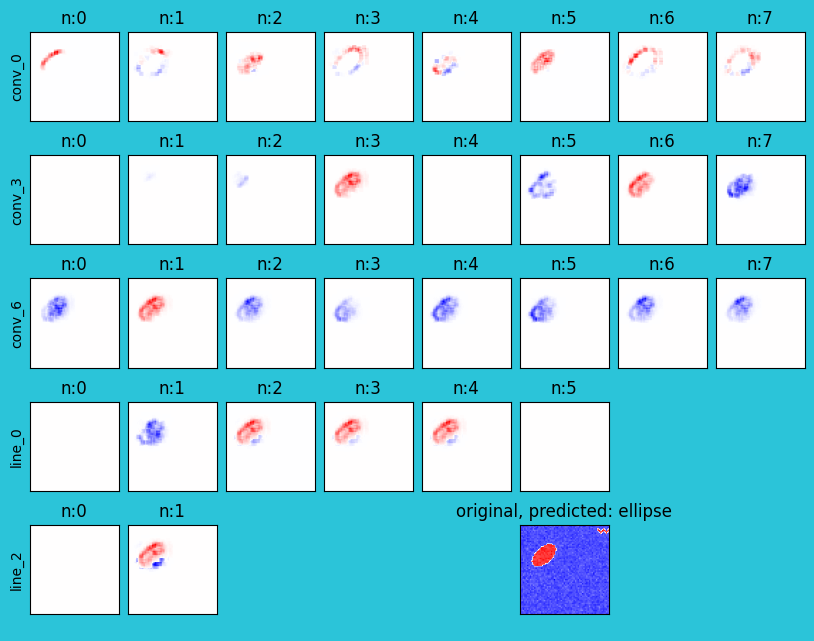

In [33]:
res = crp_attribution.image_info(nn_idx[1][0], True)

In [18]:
from expbasics.visualizations import my_plot_grid


def show_neighbors(hms, index):
    maxv = max(float(hms[index].max()), 0.001)
    minv = min(float(hms[index].min()), -0.001)
    center = 0.0
    return imgify(
        hms[index],
        vmax=maxv,
        vmin=minv,
        symmetric=True,
        grid=(
            math.floor(math.sqrt(NUM_NEIGHBORS)),
            math.floor(math.sqrt(NUM_NEIGHBORS)),
        ),
    )


def show_all_cavs(hms):
    f, ax = plt.subplots(
        1, N_BASIS, figsize=(20, 12), gridspec_kw={"wspace": 0.1, "hspace": 0}
    )
    for n in range(N_BASIS):
        ax[n].xaxis.set_visible(False)
        ax[n].yaxis.set_visible(False)
        ax[n].imshow(show_neighbors(hms, n))


H

array([[3.66558909e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.71386000e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.73768582e+01,
        0.00000000e+00, 1.66658535e+01],
       [7.49878972e+00, 0.00000000e+00, 0.00000000e+00, 8.63154208e-03,
        1.07590323e+01, 0.00000000e+00],
       [5.17135122e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.91602193e+00]])

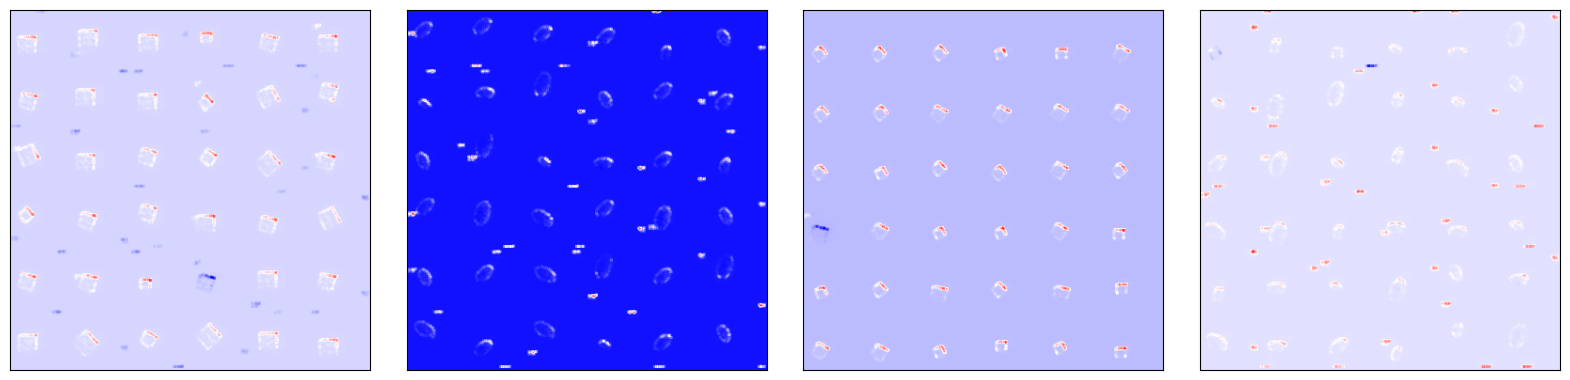

In [34]:
show_all_cavs(t)

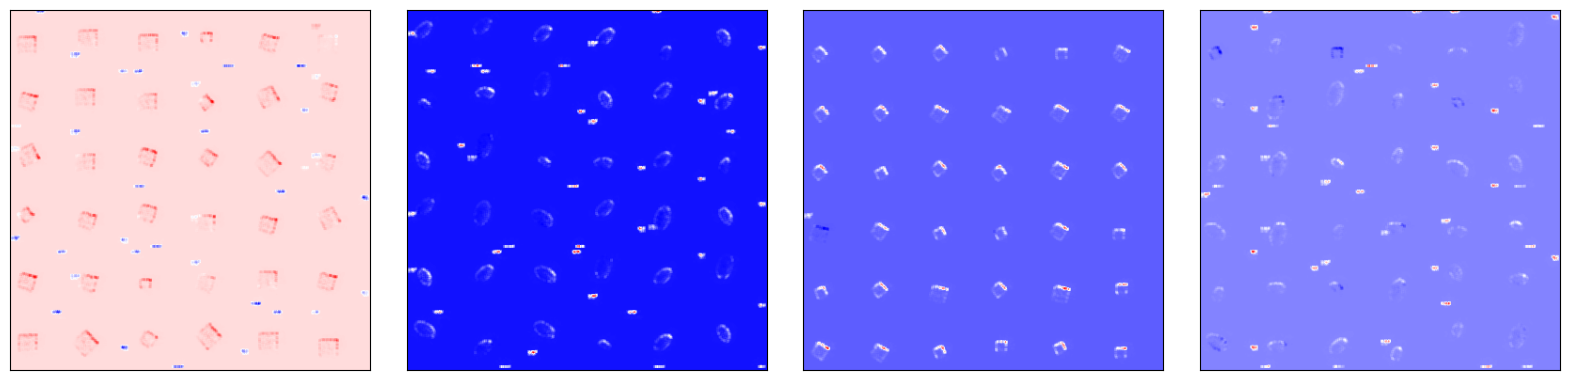

In [20]:
show_all_cavs(told)

In [21]:
H,  [np.intersect1d(nn_idx[x], nn_idx[y]).shape if x != y else "same" for x in range(4) for y in range(4)]


(array([[3.66558909e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         5.71386000e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.73768582e+01,
         0.00000000e+00, 1.66658535e+01],
        [7.49878972e+00, 0.00000000e+00, 0.00000000e+00, 8.63154208e-03,
         1.07590323e+01, 0.00000000e+00],
        [5.17135122e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 6.91602193e+00]]),
 ['same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same'])

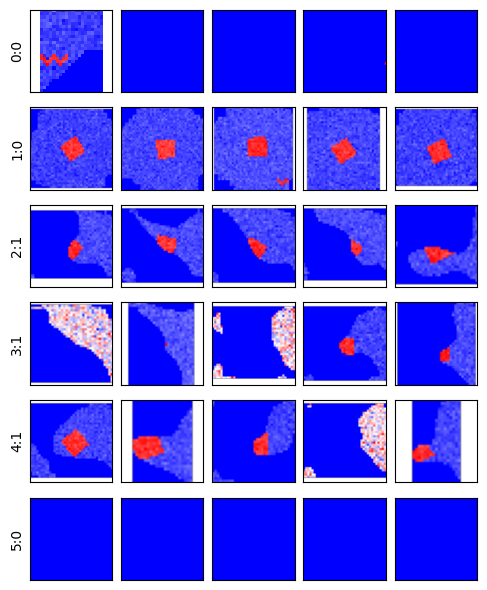

In [35]:
crp_attribution.make_all_relevances("linear_layers.0", range(6))

In [1]:
L1  https://transformer-circuits.pub/2023/monosemantic-features

TCAV -> 

multipliziere activations in latent space mit basisvektoren 
https://arxiv.org/abs/2303.12641

SyntaxError: invalid syntax (911830306.py, line 1)